DATASET LOADER

In [70]:
import os
import random
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [71]:
class SketchPhotoDataset(Dataset):
    def __init__(self, sketch_dir, photo_dir):
        self.sketch_dir = sketch_dir
        self.photo_dir = photo_dir

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]
            )
        ])

        self.pairs = self._build_pairs()

    def _get_identity(self, filename):
        # f-001-01-sz1.jpg → f-001-01
        return filename.split("-sz")[0]

    def _build_pairs(self):
        pairs = []

        photo_map = {
            os.path.splitext(f)[0]: f
            for f in os.listdir(self.photo_dir)
            if f.lower().endswith(('.jpg', '.png', '.bmp'))
        }

        for sketch_file in os.listdir(self.sketch_dir):
            if not sketch_file.lower().endswith(('.jpg', '.png', '.bmp')):
                continue

            identity = self._get_identity(sketch_file)

            if identity in photo_map:
                sketch_path = os.path.join(self.sketch_dir, sketch_file)
                photo_path  = os.path.join(self.photo_dir, photo_map[identity])
                pairs.append((sketch_path, photo_path))

        print(f"[INFO] Matched sketch-photo pairs: {len(pairs)}")
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        sketch_path, photo_path = self.pairs[idx]

        sketch = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)
        photo  = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)

        if sketch is None:
            raise FileNotFoundError(f"Sketch unreadable: {sketch_path}")
        if photo is None:
            raise FileNotFoundError(f"Photo unreadable: {photo_path}")

        sketch = cv2.cvtColor(sketch, cv2.COLOR_GRAY2RGB)
        photo  = cv2.cvtColor(photo, cv2.COLOR_GRAY2RGB)

        return self.transform(sketch), self.transform(photo)

SIAMESE NETWORK

In [72]:
import torch.nn as nn
import torchvision.models as models

In [73]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(2048, embedding_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = nn.functional.normalize(x, p=2, dim=1)
        return x

LOSS FUNCTION

In [74]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, emb1, emb2, label):
        dist = nn.functional.pairwise_distance(emb1, emb2)
        loss = label * dist.pow(2) + (1 - label) * (self.margin - dist).clamp(min=0).pow(2)
        return loss.mean()


Training Func

In [75]:
from torch.utils.data import DataLoader

In [76]:
dataset = SketchPhotoDataset(r"../dataset/sketches", r"../dataset/photos")
loader = DataLoader(dataset, batch_size=16, shuffle=True)

[INFO] Matched sketch-photo pairs: 100


In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [78]:
model = Encoder().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

d:\Python\Netra-X\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Netra-X\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [79]:
for epoch in range(10):
    model.train()
    total_loss = 0

    for sketch, photo in loader:
        sketch, photo = sketch.to(device), photo.to(device)
        label = torch.ones(sketch.size(0)).to(device)

        emb1 = model(sketch)
        emb2 = model(photo)

        loss = criterion(emb1, emb2, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

Epoch 1, Loss: 0.1158
Epoch 2, Loss: 0.0137
Epoch 3, Loss: 0.0043
Epoch 4, Loss: 0.0021
Epoch 5, Loss: 0.0014
Epoch 6, Loss: 0.0010
Epoch 7, Loss: 0.0008
Epoch 8, Loss: 0.0007
Epoch 9, Loss: 0.0006
Epoch 10, Loss: 0.0005


SAME MODEL

In [92]:
torch.save(model.state_dict(), "sketch_matcher.pth")

In [80]:
model.eval()

Encoder(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

Photo Embedding (ONE TIME)

In [81]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [82]:
import torch
import os

photo_embeddings = []
photo_paths = []

with torch.no_grad():
    for sketch_path, photo_path in dataset.pairs:
        img = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = transform(img).to(device)

        emb = model(img.unsqueeze(0))
        photo_embeddings.append(emb.cpu())
        photo_paths.append(photo_path)

photo_embeddings = torch.cat(photo_embeddings)


MODEL TESTING

In [83]:
import torch.nn.functional as F

def test_single_sketch(sketch_path):
    img = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = transform(img).to(device)

    with torch.no_grad():
        sketch_emb = model(img.unsqueeze(0))
        sims = F.cosine_similarity(sketch_emb, photo_embeddings)

    best_idx = torch.argmax(sims).item()
    return photo_paths[best_idx], sims[best_idx].item()

In [84]:
import numpy as np

sims_correct = []
sims_wrong = []

for sketch_path, true_photo_path in dataset.pairs:
    pred_photo, sim = test_single_sketch(sketch_path)

    if os.path.basename(pred_photo) == os.path.basename(true_photo_path):
        sims_correct.append(sim)
    else:
        sims_wrong.append(sim)

print("Correct sims:", np.mean(sims_correct))
print("Wrong sims:", np.mean(sims_wrong))


Correct sims: 0.9988419279623567
Wrong sims: 0.9987995787100359


Predicted photo: ../dataset/photos\m-069-01.jpg
Similarity score: 0.9988734126091003


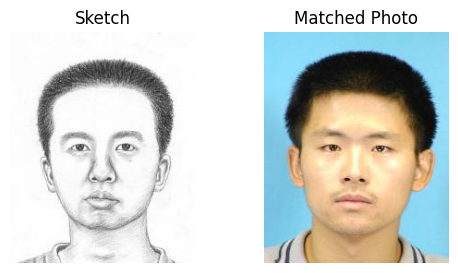

In [105]:
import matplotlib.pyplot as plt
sketch_path = r"..\dataset\sketches\M2-053-01-sz1.jpg"
best_photo, score = test_single_sketch(sketch_path)

print("Predicted photo:", best_photo)
print("Similarity score:", score)

sketch_img = cv2.imread(sketch_path)
photo_img = cv2.imread(best_photo)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Sketch")
plt.imshow(cv2.cvtColor(sketch_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Matched Photo")
plt.imshow(cv2.cvtColor(photo_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



RANK 1 SCORE

In [91]:
correct = 0

for sketch_path, true_photo_path in dataset.pairs:
    pred_photo, _ = test_single_sketch(sketch_path)
    if os.path.basename(pred_photo) == os.path.basename(true_photo_path):
        correct += 1

rank1 = correct / len(dataset.pairs)
print("Rank-1 Accuracy:", rank1)


Rank-1 Accuracy: 0.89
